<a href="https://colab.research.google.com/github/Roger-G/Data-augmentation/blob/master/fasttext_classification_sub_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package

In [3]:
from IPython.display import clear_output
! git clone https://github.com/facebookresearch/fastText.git
% cd ./fastText
! pip install .
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

Cloning into 'fastText'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 3840 (delta 1), reused 7 (delta 1), pack-reused 3826
Receiving objects: 100% (3840/3840), 8.21 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (2410/2410), done.
/content/fastText
Processing /content/fastText
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3008348 sha256=53b268b926a3785b099c19c66ad02df6f750c293419dd04179f57e7581fce211
  Stored in directory: /tmp/pip-ephem-wheel-cache-cenx86qa/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading 

True

In [0]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import fasttext
import numpy as np

from sklearn.utils import resample
from tqdm import trange
from sklearn.metrics import precision_recall_fscore_support as score
import random
import shutil
import csv
import os
from sklearn.model_selection import train_test_split
import os.path as path
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='once')
clear_output()

## Preprocessor

In [0]:
class Preprocessor():

  def __init__(self, path_, file_name, format_type):
    # abspath : the path of dataset
    
    self.path = path_
    self.file_name = file_name
    self.format_type = format_type
    
  @staticmethod
  def normalizeString(s):
    s = s.str.lower()
    s = s.str.replace(r"<br />"," ")
    s = s.str.replace(r'(\W)(?=\1)', '')
    # s = s.str.replace(r"([.!?])", " \1")
    s = s.str.replace(r'\d', '')
    s = s.str.replace(r"[^a-zA-Z.!?]+", " ")
    s = s.str.replace(r"[\.\(\)\,\!\?\:\;\-\=]"," ")

    return s
  
  @staticmethod
  def load_data(path_, FILE_NAME):
    
    df_train = pd.read_csv(os.path.join(path_,'train.tsv'), sep='\t',  error_bad_lines=False)
    df_train = df_train.dropna()
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())

    if FILE_NAME != 'oversampling':
    
      df = pd.read_csv(os.path.join(path_, FILE_NAME + '.tsv'), sep='\t',  error_bad_lines=False)    
      df = df.dropna()
    
    else:
      # 选出差额， 补到原数据上面
      df_over_samp = resample(df_train[df_train.label==0], n_samples=num_DA, random_state=100, replace=True)
      df = pd.concat([df_over_samp, df_train])

    if FILE_NAME != 'train' and FILE_NAME != 'dev' and FILE_NAME != 'oversampling' and FILE_NAME != 'test':
      try:
        df_over_samp = resample(df, n_samples=num_DA, replace = False, random_state=10) 
        
      except ValueError:
        df_over_samp = resample(df, n_samples=num_DA, replace = True, random_state=10) 
        
      df = pd.concat([df_train, df_over_samp]) 

    else: 
      pass

    df = df.sample(frac=1, replace=False, random_state=102)  

    return df
 
  def label_modify(self, data):
    
    data.sentence = self.normalizeString(data.sentence)
    data.label = data.label.apply(lambda x: '__label__' + str(x))
    return data

  def data_split(self):
    self.data = self.label_modify(self.data)

    df_dev = pd.read_csv(os.path.join(self.path, 'test.tsv'), sep='\t').dropna().reset_index()
    self.df_dev = self.label_modify(df_dev)
    

    if self.format_type=='tsv':
      self.data.to_csv(os.path.join(self.path, '{}.txt'.format(self.file_name)),
                                         sep='\t', index = False, header = False)
      self.df_dev.to_csv(os.path.join(self.path, 'test.txt'), sep='\t', index = False, header = False)
      
    else:
      self.data.to_csv(os.path.join(self.path, '{}.txt'.format(self.file_name)),
                                         sep='\t', index = False, header = False)
    
  def eval_matrix(self, label_list, pred_list):
    correct = sum([1 for i in range(len(label_list)) if pred_list[i]==label_list[i]])
    self.precision, self.recall, self.fscore, _ = score(label_list, pred_list) # 每个 class 单独的参数
    # the second score function is to get average score of evaluation matrix.
    self.precision_avg, self.recall_avg, self.fscore_avg, _ = score(label_list, pred_list, average='macro' ) 
    acc = correct / len(label_list)
    return acc

  def train_and_test(self):
    self.data  = self.load_data(self.path, self.file_name)
    self.data_split()
    model = fasttext.train_supervised(os.path.join(self.path, '{}.txt'.format(self.file_name)))
    pred_labels = []
    labels = self.df_dev.label.tolist()
    
    for i in range(len(self.df_dev)):
      pred_labels.append(model.predict(self.df_dev.loc[i].sentence)[0][0])
    
    acc = self.eval_matrix(labels, pred_labels)

    return model, acc, self.precision_avg, self.recall_avg, self.fscore_avg, self.precision, self.recall, self.fscore
    

# Until

In [0]:
class utils():
  
  def __init__(self, EPOCHS):
    self.EPOCHS = EPOCHS

  def acc_loss(self, list_train_acc, list_val_acc, list_train_loss, list_val_loss):
    fig = plt.figure(figsize=(10, 5))
    
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(ax=ax1, data=pd.DataFrame(list(zip(list_train_acc, list_val_acc)), columns=['training acc', 'validation acc'], index = range(1, len(list_val_acc)+1)))
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.locator_params(integer=True)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.lineplot(ax=ax2, data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=['training loss', 'validation loss'], index = range(1, len(list_val_loss)+1)))
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.locator_params(integer=True)
    plt.show()
  
  @staticmethod
  def draw_final(eval_dic, test_list_name):
    
    for eval_name, eval_list in eval_dic.items():
      sns.set(style="white", context="talk")
      plt.figure(figsize=(10,5)) 
      g = sns.barplot(x=np.array(eval_list), y=np.array(test_list_name), palette="deep")
      ax=g
    
      for p in ax.patches:
        ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
          fontsize=12, color='gray', xytext=(10, 0), textcoords='offset points')
    
      ax.axhline(0, color="k", clip_on=False)
      ax.set_xlabel(eval_name)
      # ax.set_ylabel("Methods")

  @staticmethod
  def path_setting(task_name, tech_name = 'Bert_ data augmentation-master'):
    abspath = '/content/drive/My Drive/Data/'
    model_path = path.join(abspath, tech_name + '/save_model')
    dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
    save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))
    return model_path, dataset_path, save_path

  @staticmethod
  def eval_matrix(list_array_value):
    fig = plt.figure(figsize=(12, 5))
  
    for i, array_value in enumerate(list_array_value):
      df = pd.DataFrame(array_value, columns=["0", "1", "2"], index=range(1,len(array_value)+1))
      ax = fig.add_subplot(1, 3, i+1)
      sns.lineplot(data=df, palette="tab10", ax=ax)
      ax.set(xlabel='Epochs', ylabel=['precision', 'recall', 'fscore'][i])

    plt.show()
  
  @staticmethod
  def draw_other_final(list_array_dic, test_list):

    for eval_name, list_array in list_array_dic.items():
      fig1 = plt.figure(figsize=(10, 5))
      barWidth = 0.07
      colors = ['#486093', '#BF7651', '#4F8F5B', '#A4484E', '#72659A', '#7A6553', '#C47FB2']
      # Set position of bar on X axis
      r1 = np.arange(len(list_array[0]))
      plt.bar(r1, list_array[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
      for i in range(1, len(list_array)):
        r1 = [x + barWidth for x in r1] 
        plt.bar(r1, list_array[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  
    
      # Add xticks on the middle of the group bars
      plt.xlabel('class', fontweight='bold')
      plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['negative', 'neutral', 'positive'])
      plt.ylabel(eval_name)
      # Create legend & Show graphic
      plt.legend()
      plt.show()
    


# Classification

## Classifier

In [0]:
# Fasttext clf to test Bert DA
class Clfier():

  def __init__(self, task_name, tech_name):
    self.task_name = task_name
    self.tech_name = tech_name
    

  @staticmethod
  def path_setting(task_name, tech_name):
      abspath = '/content/drive/My Drive/Data/'
      model_path = path.join(abspath, tech_name + '/save_model')
      dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
      save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))

      return save_path

  def clf(self, file_name):

    save_path = self.path_setting(self.task_name, self.tech_name)
    if self.tech_name == 'Bert_ data augmentation-master' and self.task_name == 'rt-polaritydata':
      path_ = os.path.join(save_path, 'replacement')
    else:
      path_ = save_path

    df_train = pd.read_csv(os.path.join(path_, 'train.tsv'), sep='\t')
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())

    file_type = 'tsv'
      
    print('-' * 70)
    print('Start to train model use the data : {}'.format(file_name))
    print('-' * 70)
    
    preprocessor = Preprocessor(path_, file_name,  file_type)
    model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = preprocessor.train_and_test()

    print('              negative    neutral     positive')
    print('precision:', precision)
    print('recall:   ', recall)
    print('f1 score: ', fscore)
    print('-'*50)
    print("accuracy: %.2f%%" % (acc*100))
    print("precision: %.2f%%" % (precision_avg*100))
    print("recall: %.2f%%" % (recall_avg*100))
    print("f1 score: %.2f%%" % (fscore_avg*100))
      
    
    return model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore


## 实例化并调用

In [8]:
%%time
def execute(test_list, task_name, tech_name):

  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_prec = []
  list_recall = []
  list_fs = []

  # model_path, dataset_path, save_path = path_setting(task_name, tech_name)
  clfer = Clfier(task_name, tech_name)

  for file_name in test_list:

    model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = clfer.clf(file_name)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

    acc_list.append(acc)
    list_prec.append(precision_avg)
    list_recall.append(recall_avg)
    list_fs.append(fscore_avg)

  utils.draw_final({
                    'accuracy': acc_list, 
                    'average fscore': list_fs, 
                    'average precision': list_prec,
                    'average recall': list_recall}, test_list)

  utils.draw_other_final( {'precision': precision_list, 
                    'recall': recall_list, 'fscore': fscore_list}, test_list)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


In [0]:
# test_list = [
#       'train',
#       'oversampling',
#       '2_rep',
#       '3_rep',
#       '4_rep',
#       '5_rep',
      
#       ]
# task_name = 'sub_twitter'
# tech_name = 'Fasttext_augmentation'
# execute(test_list, task_name, tech_name)

### *EDA*

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.45487365 0.67812818 0.70414508]
recall:    [0.1826087  0.74747701 0.69638739]
f1 score:  [0.26059979 0.71111585 0.70024475]
--------------------------------------------------
accuracy: 68.24%
precision: 61.24%
recall: 54.22%
f1 score: 55.73%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.30252101 0.69062286 0.72123402]
recall:    [0.46956522 0.67885176 0.66487317]
f1 score:  [0.36797274 0.68468672 0.69190775]
--------------------------------------------------
accuracy: 65.69%
precision: 57.15%
recall: 60.44%
f1 score: 58.15%
-------------------

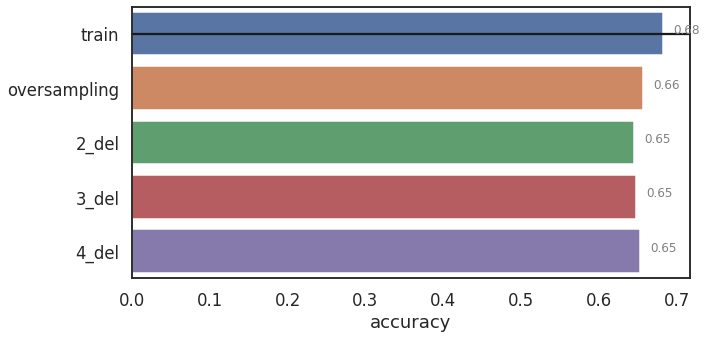

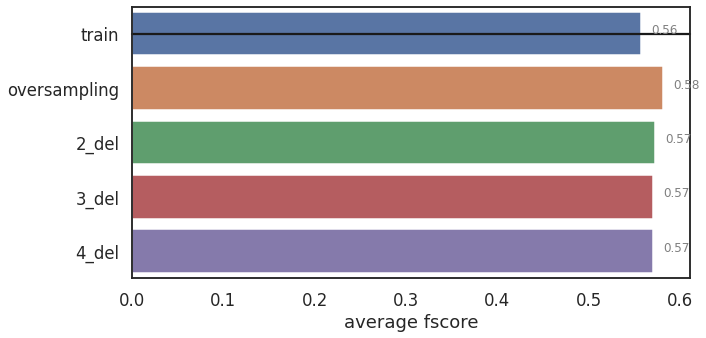

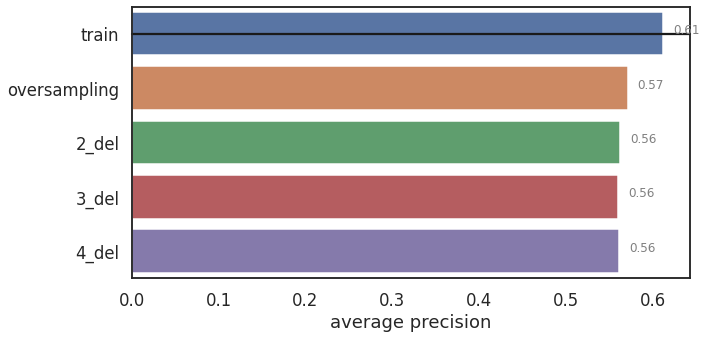

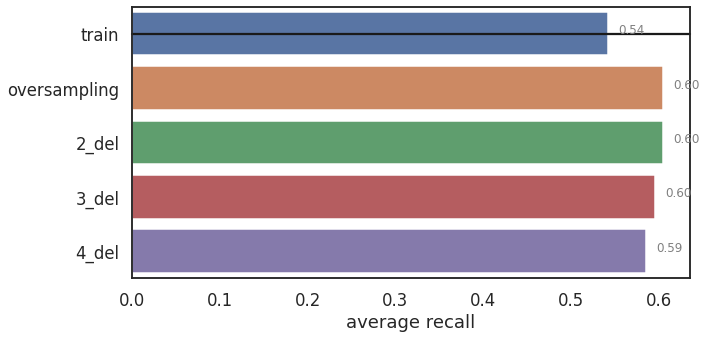

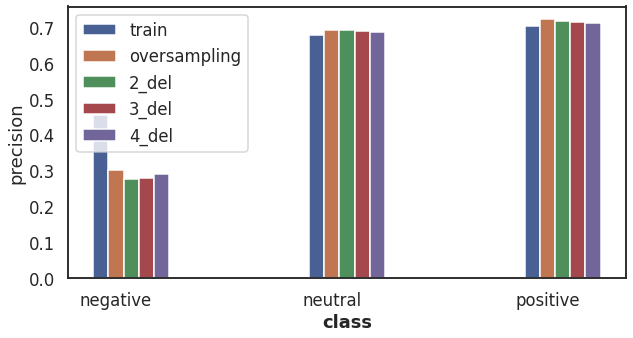

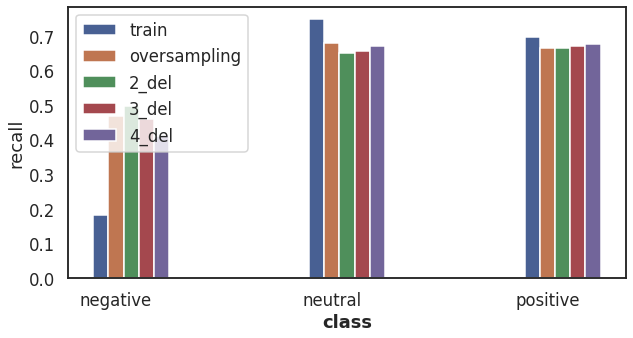

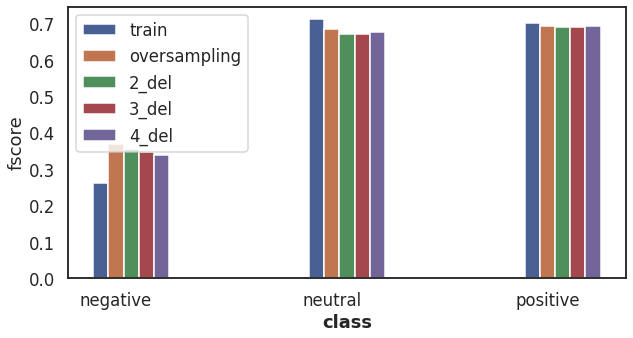

In [11]:
test_list = [
      'train',
      'oversampling',
      '2_del',
      '3_del',
      '4_del',
      # '5_del',
      
      ]

task_name = 'sub_twitter'
tech_name = 'EDA'
execute(test_list, task_name, tech_name)

### *Fasttext test dataset*

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.45487365 0.67812818 0.70414508]
recall:    [0.1826087  0.74747701 0.69638739]
f1 score:  [0.26059979 0.71111585 0.70024475]
--------------------------------------------------
accuracy: 68.24%
precision: 61.24%
recall: 54.22%
f1 score: 55.73%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.30252101 0.69062286 0.72123402]
recall:    [0.46956522 0.67885176 0.66487317]
f1 score:  [0.36797274 0.68468672 0.69190775]
--------------------------------------------------
accuracy: 65.69%
precision: 57.15%
recall: 60.44%
f1 score: 58.15%
-------------------

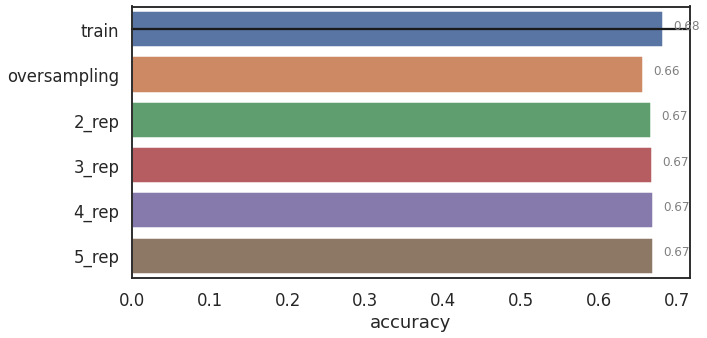

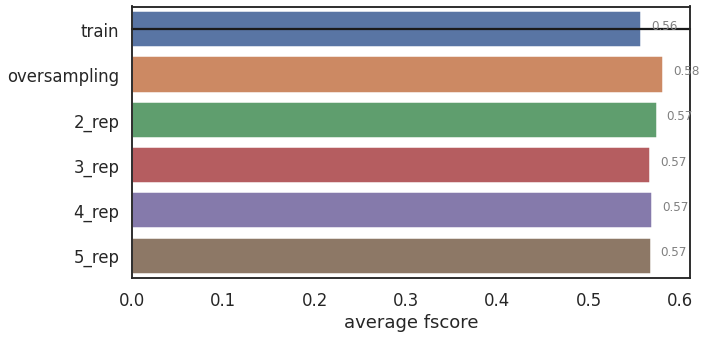

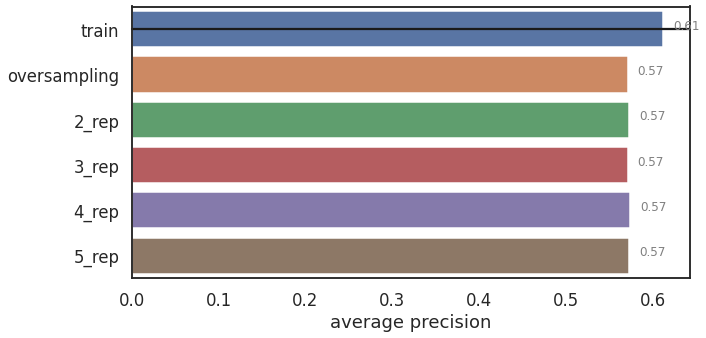

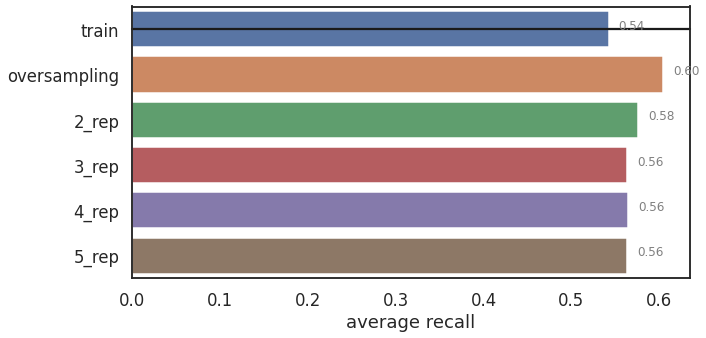

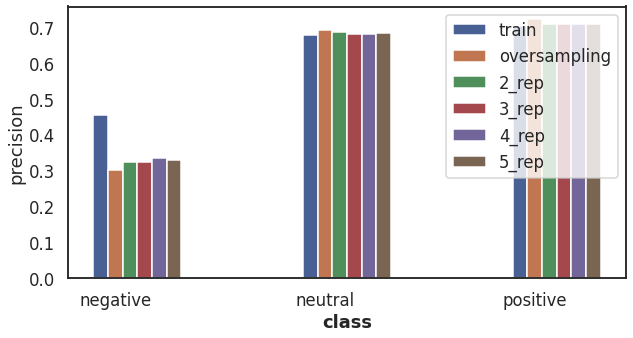

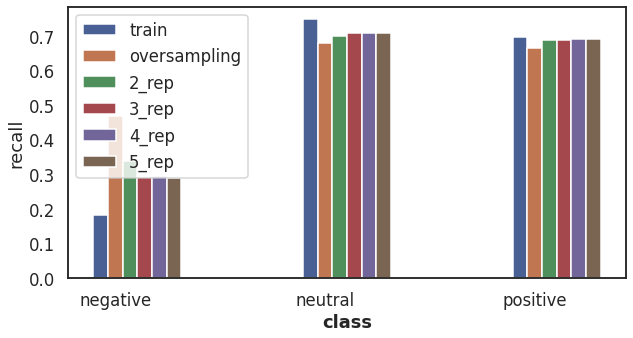

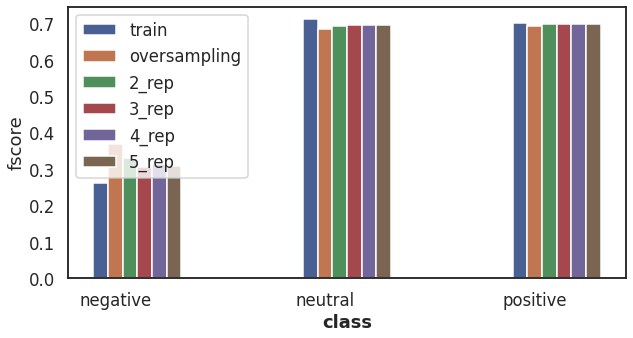

In [12]:
test_list = [
      'train',
      'oversampling',
      '2_rep',
      '3_rep',
      '4_rep',
      '5_rep',
      
      ]
task_name = 'sub_twitter'
tech_name = 'Fasttext_augmentation'
execute(test_list, task_name, tech_name)

### *Back_translation*

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.45487365 0.67812818 0.70414508]
recall:    [0.1826087  0.74747701 0.69638739]
f1 score:  [0.26059979 0.71111585 0.70024475]
--------------------------------------------------
accuracy: 68.24%
precision: 61.24%
recall: 54.22%
f1 score: 55.73%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.30252101 0.69062286 0.72123402]
recall:    [0.46956522 0.67885176 0.66487317]
f1 score:  [0.36797274 0.68468672 0.69190775]
--------------------------------------------------
accuracy: 65.69%
precision: 57.15%
recall: 60.44%
f1 score: 58.15%
-------------------

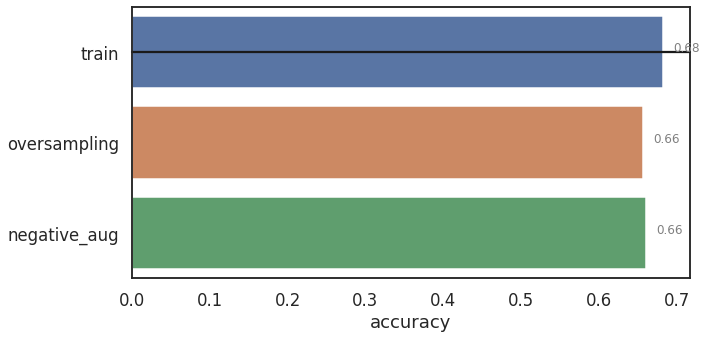

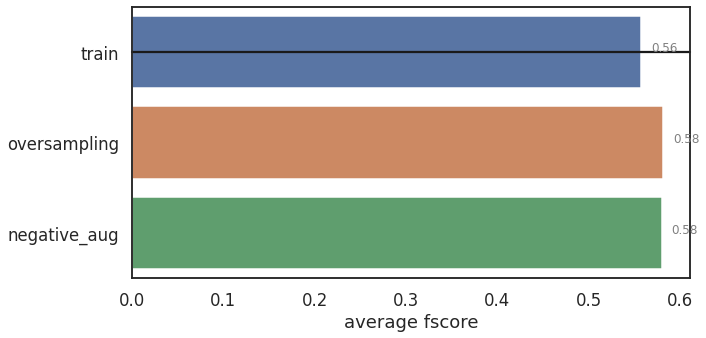

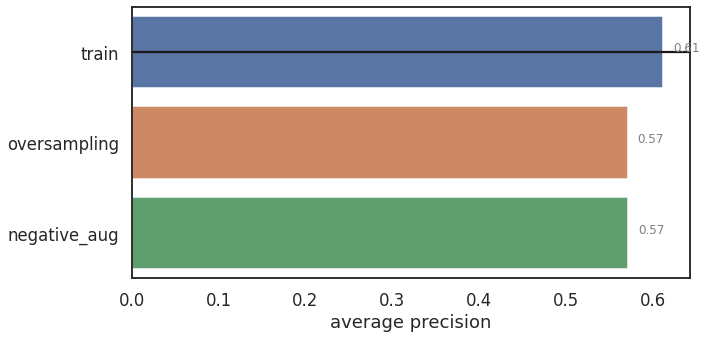

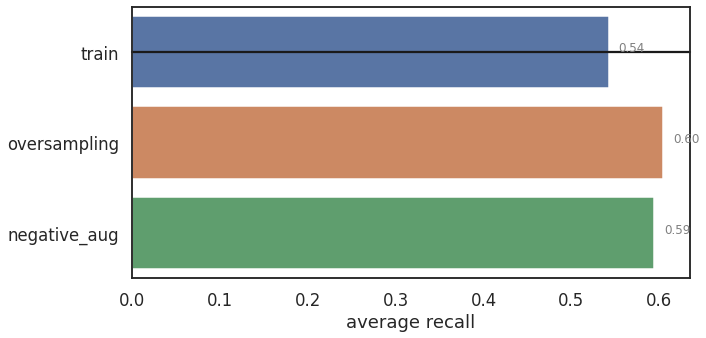

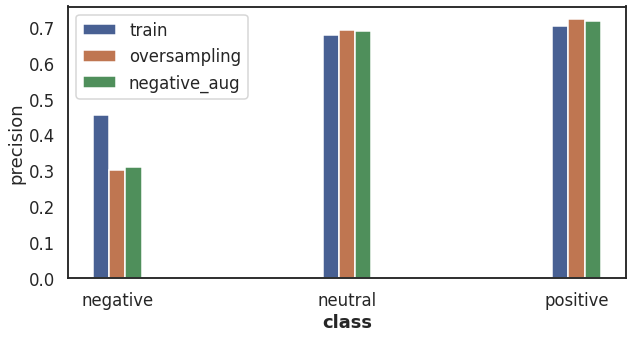

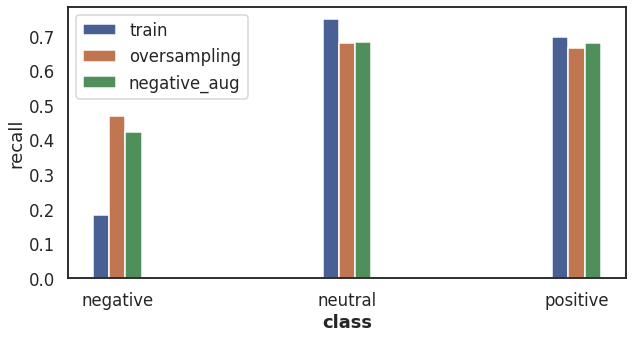

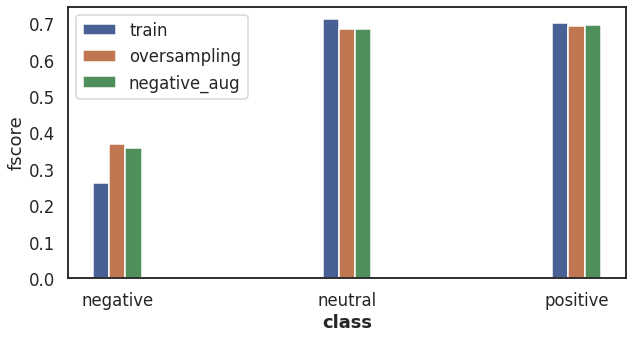

CPU times: user 15.7 s, sys: 417 ms, total: 16.1 s
Wall time: 19.1 s


In [13]:
%%time

if __name__ == "__main__":
  task_name = 'sub_twitter'
  tech_name = 'Back_trans'
  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_prec = []
  list_recall = []
  list_fs = []
  test_list = [
        'train',
        'oversampling',
        'negative_aug',
        
        ]
  # model_path, dataset_path, save_path = path_setting(task_name, tech_name)
  clfer = Clfier(task_name, tech_name)

  for file_name in test_list:

    model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = clfer.clf(file_name)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

    acc_list.append(acc)
    list_prec.append(precision_avg)
    list_recall.append(recall_avg)
    list_fs.append(fscore_avg)

  utils.draw_final({
                    'accuracy': acc_list, 
                    'average fscore': list_fs, 
                    'average precision': list_prec,
                    'average recall': list_recall}, test_list)

  utils.draw_other_final( {'precision': precision_list, 
                    'recall': recall_list, 'fscore': fscore_list}, test_list)

## Back_translation


### *Fine-tuned BERT*

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.45487365 0.67812818 0.70414508]
recall:    [0.1826087  0.74747701 0.69638739]
f1 score:  [0.26059979 0.71111585 0.70024475]
--------------------------------------------------
accuracy: 68.24%
precision: 61.24%
recall: 54.22%
f1 score: 55.73%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.30252101 0.69062286 0.72123402]
recall:    [0.46956522 0.67885176 0.66487317]
f1 score:  [0.36797274 0.68468672 0.69190775]
--------------------------------------------------
accuracy: 65.69%
precision: 57.15%
recall: 60.44%
f1 score: 58.15%
-------------------

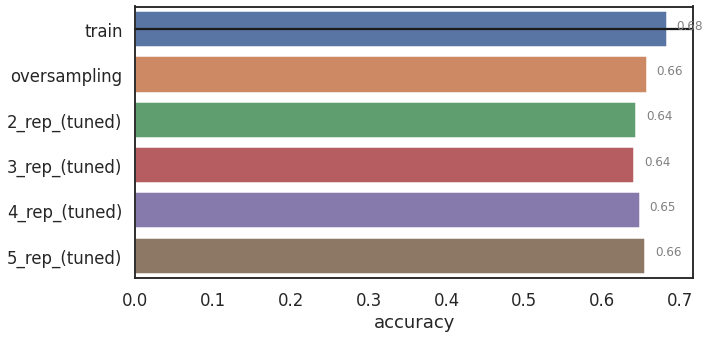

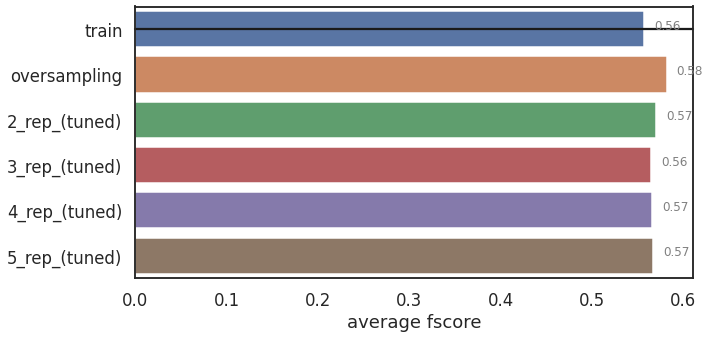

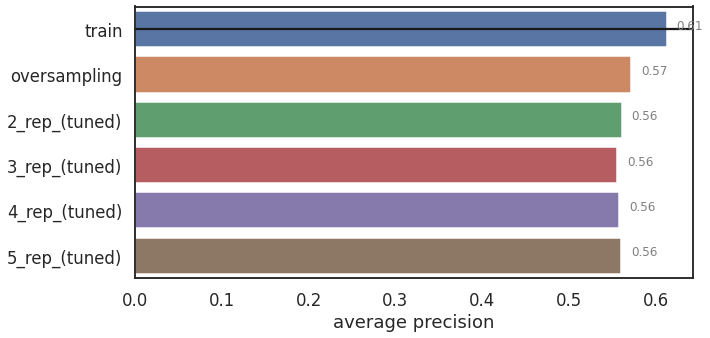

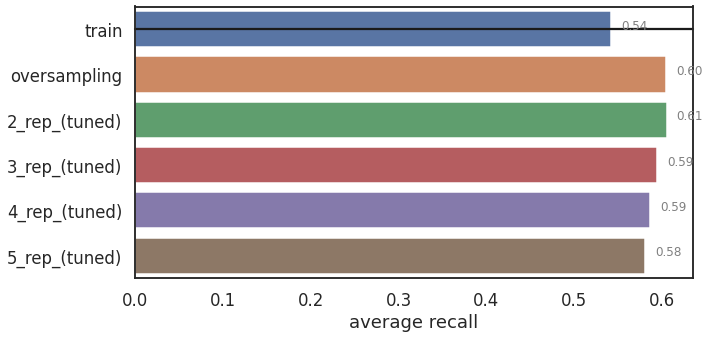

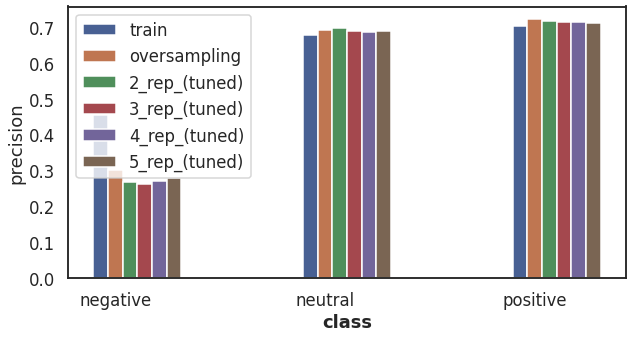

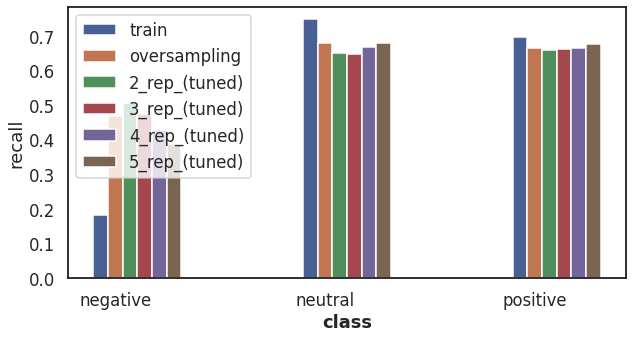

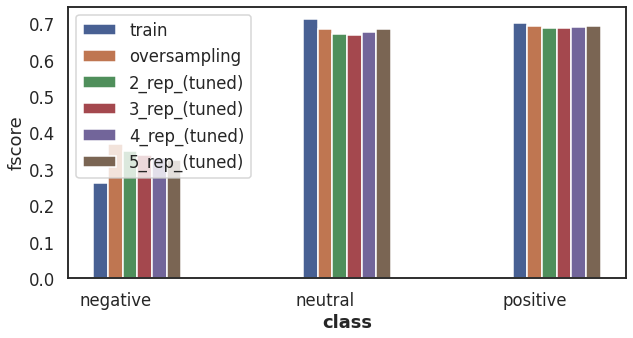

CPU times: user 30.6 s, sys: 549 ms, total: 31.2 s
Wall time: 38.4 s


In [15]:
%%time

if __name__ == "__main__":
  task_name = 'sub_twitter'
  tech_name = 'Bert_ data augmentation-master'
  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_prec = []
  list_recall = []
  list_fs = []
  test_list = [
        'train',
        # 'backtrans'
        'oversampling',
        '2_rep_(tuned)',
        '3_rep_(tuned)',
        '4_rep_(tuned)',
        '5_rep_(tuned)',
        # '6_rep_(tuned)',
        
        ]
  # model_path, dataset_path, save_path = path_setting(task_name, tech_name)
  clfer = Clfier(task_name, tech_name)

  for file_name in test_list:

    model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = clfer.clf(file_name)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

    acc_list.append(acc)
    list_prec.append(precision_avg)
    list_recall.append(recall_avg)
    list_fs.append(fscore_avg)

  utils.draw_final({
                    'accuracy': acc_list, 
                    'average fscore': list_fs, 
                    'average precision': list_prec,
                    'average recall': list_recall}, test_list)

  utils.draw_other_final( {'precision': precision_list, 
                    'recall': recall_list, 'fscore': fscore_list}, test_list)

## Fine-tuned BERT


### *Pretrain BERT*

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.45487365 0.67812818 0.70414508]
recall:    [0.1826087  0.74747701 0.69638739]
f1 score:  [0.26059979 0.71111585 0.70024475]
--------------------------------------------------
accuracy: 68.24%
precision: 61.24%
recall: 54.22%
f1 score: 55.73%
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------
              negative    neutral     positive
precision: [0.30252101 0.69062286 0.72123402]
recall:    [0.46956522 0.67885176 0.66487317]
f1 score:  [0.36797274 0.68468672 0.69190775]
--------------------------------------------------
accuracy: 65.69%
precision: 57.15%
recall: 60.44%
f1 score: 58.15%
-------------------

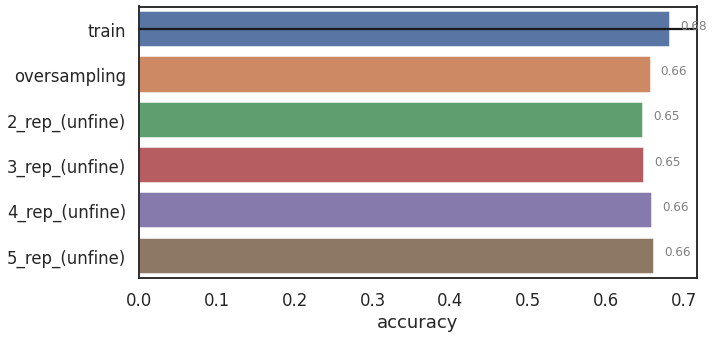

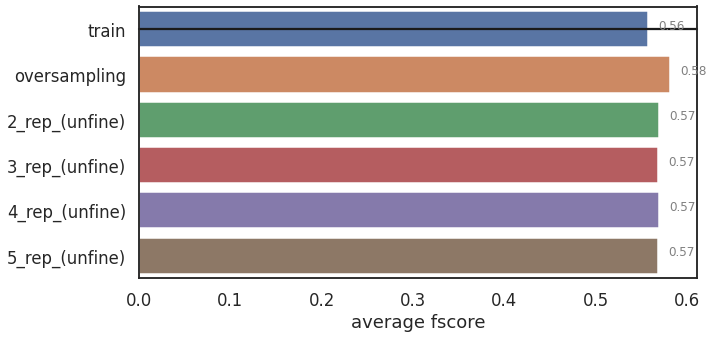

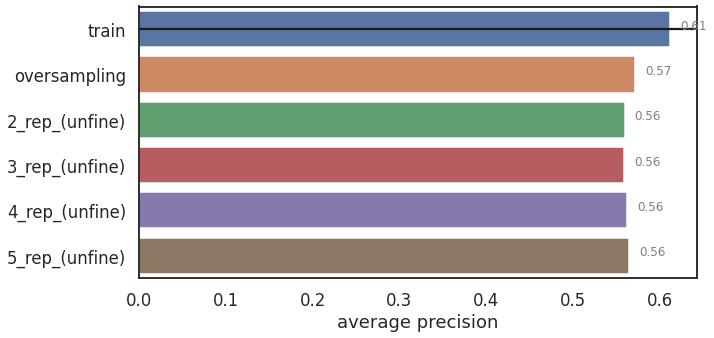

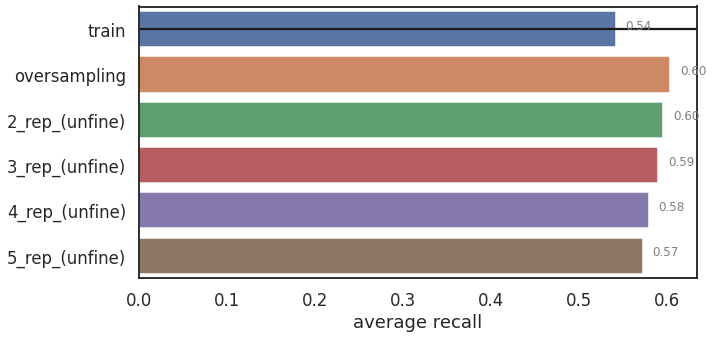

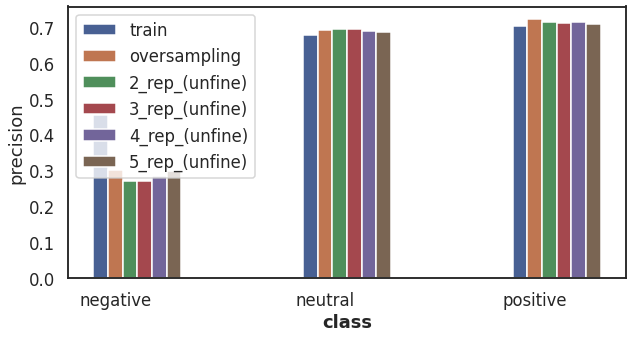

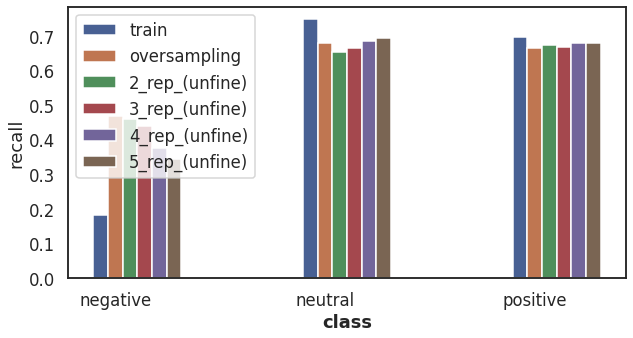

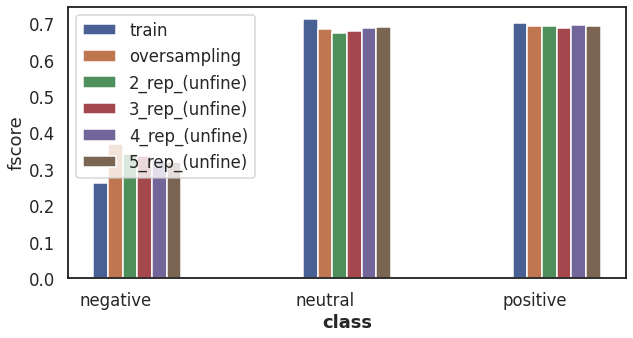

CPU times: user 30.7 s, sys: 492 ms, total: 31.2 s
Wall time: 37.8 s


In [16]:
%%time

if __name__ == "__main__":
  task_name = 'sub_twitter'
  tech_name = 'Bert_ data augmentation-master'
  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_prec = []
  list_recall = []
  list_fs = []
  test_list = [
        'train',
        # 'backtrans'
        'oversampling',
        '2_rep_(unfine)',
        '3_rep_(unfine)',
        '4_rep_(unfine)',
        '5_rep_(unfine)',
        # '6_rep_(unfine)',
        
        ]
  # model_path, dataset_path, save_path = path_setting(task_name, tech_name)
  clfer = Clfier(task_name, tech_name)

  for file_name in test_list:

    model, acc, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = clfer.clf(file_name)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

    acc_list.append(acc)
    list_prec.append(precision_avg)
    list_recall.append(recall_avg)
    list_fs.append(fscore_avg)

  utils.draw_final({
                    'accuracy': acc_list, 
                    'average fscore': list_fs, 
                    'average precision': list_prec,
                    'average recall': list_recall}, test_list)

  utils.draw_other_final( {'precision': precision_list, 
                    'recall': recall_list, 'fscore': fscore_list}, test_list)


## Pretrain BERT